# 导入必要的库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from utils import *
from models import *

import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 载入图像

In [2]:
width = 512
style_img = read_image('images/picasso.jpg', target_width=width).to(device)
content_img = read_image('images/dancing.jpg', target_width=width).to(device)

(512, 512, 3)
(512, 512, 3)


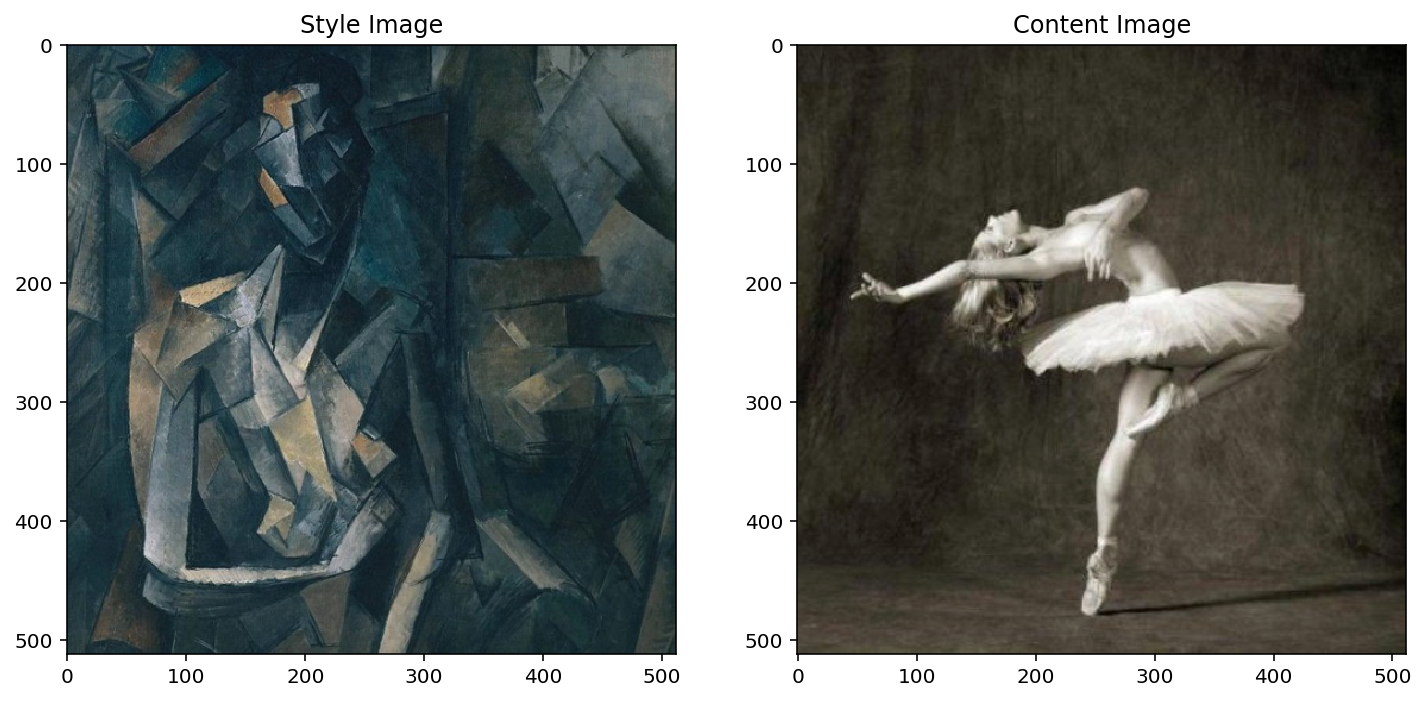

In [3]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
imshow(style_img, title='Style Image')

plt.subplot(1, 2, 2)
imshow(content_img, title='Content Image')

# 搭建模型

https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py

In [4]:
vgg16 = models.vgg16(pretrained=True)
vgg16 = VGG(vgg16.features[:23]).to(device).eval()

# 计算特征

特征为 VGG16 的 relu_1_2、relu_2_2、relu_3_3 和 relu_4_3。

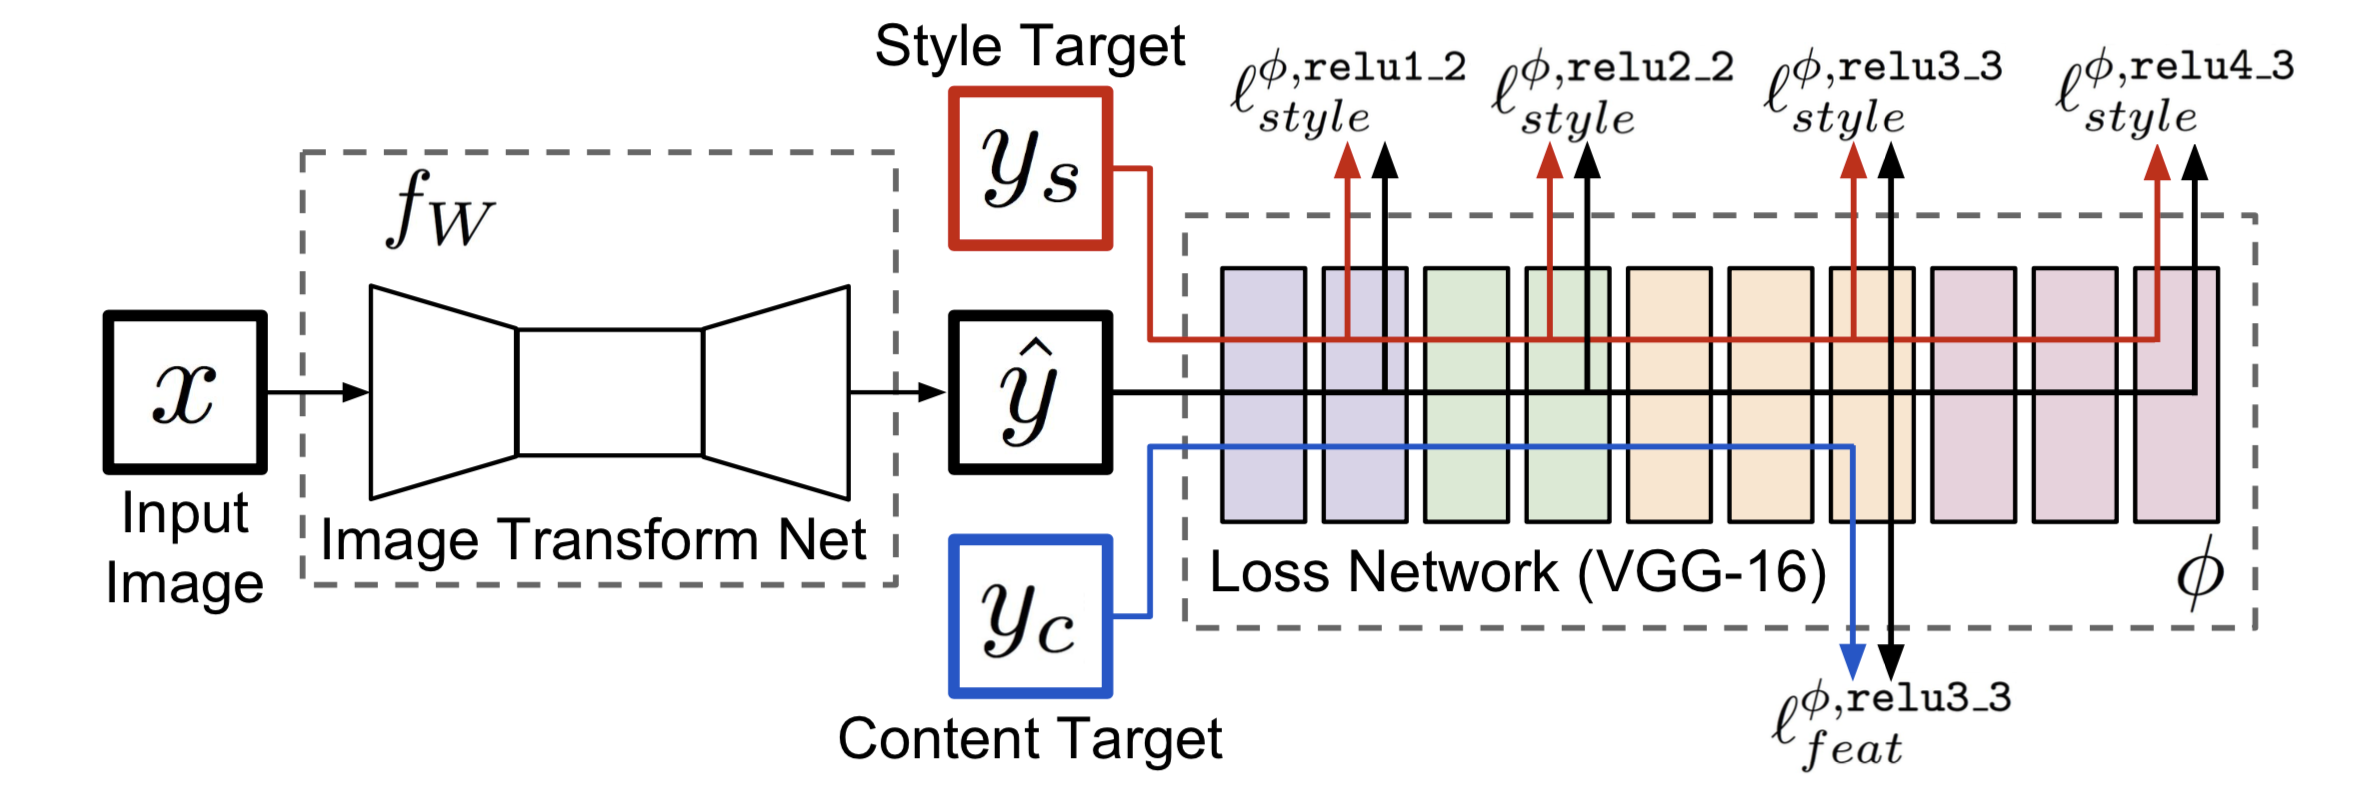

In [5]:
style_features = vgg16(style_img)
content_features = vgg16(content_img)

[x.shape for x in content_features]

[torch.Size([1, 64, 512, 512]),
 torch.Size([1, 128, 256, 256]),
 torch.Size([1, 256, 128, 128]),
 torch.Size([1, 512, 64, 64])]

# 计算 Gram 矩阵

$$\Large{G^\phi_j(x)_{c,c'}=\frac{1}{C_jH_jW_j} \sum_{h=1}^{H_j} \sum_{w=1}^{W_j} \phi_j(x)_{h,w,c}\phi_j(x)_{h,w,c'}}$$

其中：

* $G^\phi_j(x)$指的是 x 图像的第 j 层特征图对应的 Gram 矩阵，比如 64 个卷积核对应的卷积层输出的特征图的 Gram 矩阵的尺寸是 $(64, 64)$。
* $G^\phi_j(x)_{c,c'}$ 指的是 Gram 矩阵第 $(c, c')$ 坐标对应的值。
* $\phi_j(x)$指的是 x 图像输入到 VGG 以后的第 j 层的特征图，$\phi_j(x)_{h,w,c}$ 指的是特征图 $(h,w,c)$坐标对应的值。
* $C_j\times H_j\times W_j$是第 j 层输出的特征图的尺寸。

In [6]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

style_grams = [gram_matrix(x) for x in style_features]
[x.shape for x in style_grams]

[torch.Size([1, 64, 64]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 512, 512])]

# 训练图片

In [8]:
input_img = content_img.clone()
optimizer = optim.LBFGS([input_img.requires_grad_()])
style_weight = 1e6
content_weight = 1

run = [0]
while run[0] <= 300:
    def f():
        optimizer.zero_grad()
        features = vgg16(input_img)
        
        content_loss = F.mse_loss(features[2], content_features[2]) * content_weight
        style_loss = 0
        grams = [gram_matrix(x) for x in features]
        for a, b in zip(grams, style_grams):
            style_loss += F.mse_loss(a, b) * style_weight
        
        loss = style_loss + content_loss
        
        if run[0] % 50 == 0:
            print('Step {}: Style Loss: {:4f} Content Loss: {:4f}'.format(
                run[0], style_loss.item(), content_loss.item()))
        run[0] += 1
        
        loss.backward()
        return loss
    
    optimizer.step(f)

Step 0: Style Loss: 27.289558 Content Loss: 0.000000
Step 50: Style Loss: 0.448229 Content Loss: 1.049542
Step 100: Style Loss: 0.336634 Content Loss: 0.956348
Step 150: Style Loss: 0.315091 Content Loss: 0.928491
Step 200: Style Loss: 0.306336 Content Loss: 0.916211
Step 250: Style Loss: 0.301375 Content Loss: 0.909784
Step 300: Style Loss: 0.298611 Content Loss: 0.905301


# 可视化风格图片

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


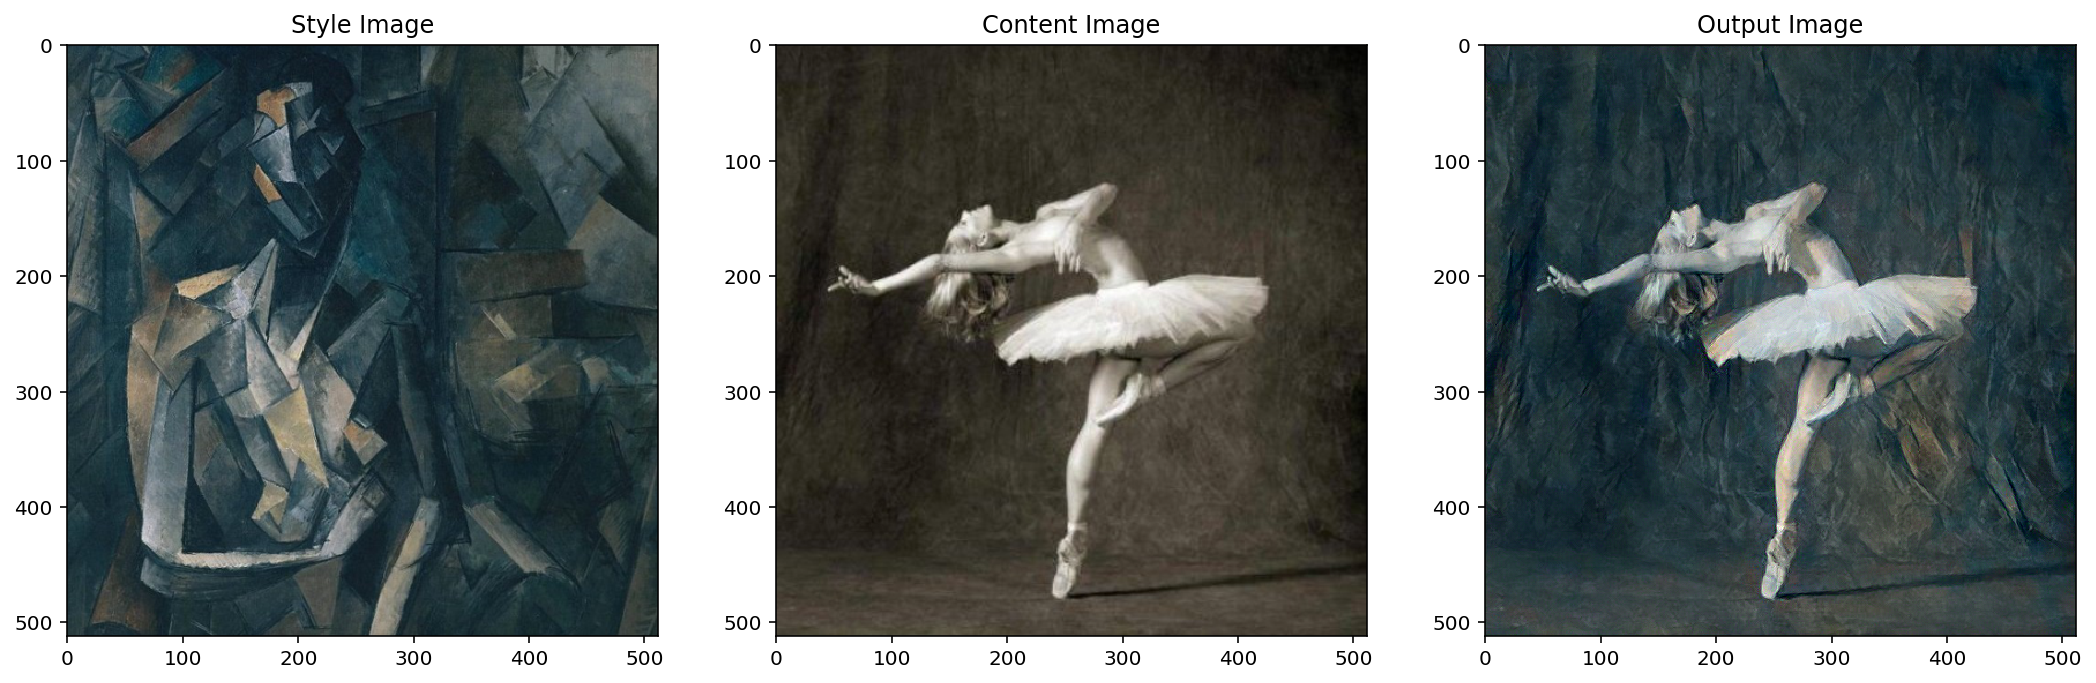

In [9]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
imshow(style_img, title='Style Image')

plt.subplot(1, 3, 2)
imshow(content_img, title='Content Image')

plt.subplot(1, 3, 3)
imshow(input_img, title='Output Image')